In [19]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import layers

In [20]:
def initiateGenerator(path):
    base_path = path
    print("\nTotal : ", end=" ")
    train_dataset = tf.keras.preprocessing.image_dataset_from_directory(batch_size=32, directory=base_path+"/"+"train")

    train_datagen = ImageDataGenerator()

    print("\nFor Training : ", end=" ")
    train_generator = train_datagen.flow_from_directory(
        base_path+"/"+"train",
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical', subset='training')

    print("\nFor Val : ", end=" ")
    valid_datagen = ImageDataGenerator()
    validation_generator = valid_datagen.flow_from_directory(
        base_path+"/"+"val",
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical',shuffle=False)
    test_datagen = ImageDataGenerator()
    test_generator = test_datagen.flow_from_directory(
        base_path+"/"+"test",
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical', shuffle=False)
    class_names = train_dataset.class_names
    noOfClasses = len(class_names)
    print("\nNo of Classes : ", noOfClasses)
    print("Classes : ", class_names)

    plt.figure(figsize=(10, 10))
    for images, labels in train_dataset.take(1):
        for i in range(noOfClasses):
            ax = plt.subplot(4, 4, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[labels[i]])
            plt.axis("off")

    for image_batch, labels_batch in train_dataset:
        print("Image Shape : ",image_batch.shape)
        break
        
    return noOfClasses,class_names, train_generator, validation_generator,test_generator

In [21]:
def initiateNormalize():
    AUTOTUNE = tf.data.AUTOTUNE

    train_ds = train_generator.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
    val_ds = val_generator.cache().prefetch(buffer_size=AUTOTUNE)
    normalization_layer = layers.Rescaling(1./255)

    normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
    image_batch, labels_batch = next(iter(normalized_ds))
    first_image = image_batch[0]
    print(np.min(first_image), np.max(first_image))

In [22]:
def initiateVGG19(noOfClasses):
    modelInput = tf.keras.applications.VGG19(
        input_shape=IMAGE_SIZE + [3],
        include_top=False,
        weights="imagenet"
    )
    
    for layer in modelInput.layers:
        layer.trainable = False
    
    x = Flatten()(modelInput.output)
    prediction = Dense(noOfClasses, activation='softmax')(x)

    model = Model(inputs=modelInput.input, outputs=prediction)
    return model

def modelSummary(model):
    model.summary()

In [23]:
def initiateDenseNet201(noOfClasses):
    modelInput = tf.keras.applications.DenseNet201(
        input_shape=IMAGE_SIZE + [3],
        include_top=False,
        weights="imagenet"
    )
    
    for layer in modelInput.layers:
        layer.trainable = False
    
    x = Flatten()(modelInput.output)
    prediction = Dense(noOfClasses, activation='softmax')(x)

    model = Model(inputs=modelInput.input, outputs=prediction)
    return model


In [24]:
def initiateMobileNetV3(noOfClasses):
    modelInput = tf.keras.applications.MobileNetV3Small(
        input_shape=IMAGE_SIZE + [3],
        include_top=False,
        weights="imagenet"
    )
    
    for layer in modelInput.layers:
        layer.trainable = False
    
    x = Flatten()(modelInput.output)
    prediction = Dense(noOfClasses, activation='softmax')(x)

    model = Model(inputs=modelInput.input, outputs=prediction)
    return model

In [25]:
def initiateParams(className, model, lr,model_name):
    opt = tf.keras.optimizers.Adam(learning_rate=lr)

    model.compile(optimizer=opt,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-3)
    checkpoint = ModelCheckpoint(className + model_name+'.h5', verbose=1, save_best_only=True)
    
    return model, annealer, checkpoint

In [26]:
def modelFit(model, annealer, checkpoint, epochs=20, batchSize = 256):

    history = model.fit(
      train_generator,
      validation_data=validation_generator,
      epochs=epochs,
      batch_size=batchSize,
      callbacks=[annealer, checkpoint],
      steps_per_epoch=len(train_generator),
      validation_steps=len(validation_generator)
    )
    
    return history


In [27]:
def plotOutput(history, className, epochs):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(12, 12))
    plt.subplot(3, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(3, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()
    plt.savefig(className + '_graph.png')

In [28]:
def evalModel(model):
    evl = model.evaluate(test_generator)
    acc = evl[1]*100
    msg=f'Accuracy on the Test Set = {acc:5.2f} %'
    print(msg)
    return acc
    
def saveModel(model, className,model_name):
    model.save(className + " - "+model_name+"Final.h5")
    print("Model Saved!")

In [29]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(15, 15))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
    plt.savefig(title + '.png')

In [30]:
from sklearn.metrics import recall_score,precision_score,f1_score
def callPlot(model, className, classes):
    y_true = test_generator.classes
    print("True : ", (y_true))

    y_pred = model.predict(test_generator)
    y_pred = np.argmax(y_pred, axis=1)
    print("Predicted : ", (y_pred))

    conf_mat = confusion_matrix(y_true, y_pred)
    recall=recall_score(y_true,y_pred,average='weighted')
    p=precision_score(y_true, y_pred,average='weighted')
    f1=f1_score(y_true, y_pred,average='weighted')
    print(f"RECALL={recall}")
    print(f"precision={p}")
    print(f"F1 Score{f1}")
    plot_confusion_matrix(cm           = conf_mat,
                          normalize    = False,
                          target_names = classes,
                          title        = className + "Confusion Matrix")

In [31]:
mpath = r'../input/multi-cancer/Dataset'
classPaths = os.listdir(mpath)

IMAGE_SIZE = [224, 224]
img_height = 224
img_width = 224
noOfClasses = 0
gEpochs = 25
lr = 0.001

In [32]:
import pprint
part={}
for c in classPaths:
#     part[c]={'models':{"EfficientNetB7":{"model":None,"accurary":0},
#                     "Densenet201":{"model":None,"accurary":0},
#                     "VGG19":{"model":None,"accurary":0},
#                     "ResnetV2":{"model":None,"accurary":0},
#                     "mobilenetV3":{"model":None,"accurary":0}
#                    },'no_of_classes':0,"ClassNames":None}
    part[c]={'models':{},'no_of_classes':0,"ClassNames":None}

In [33]:
pprint.pprint(part)

{'ALL': {'ClassNames': None, 'models': {}, 'no_of_classes': 0},
 'Brain Cancer': {'ClassNames': None, 'models': {}, 'no_of_classes': 0},
 'Breast Cancer': {'ClassNames': None, 'models': {}, 'no_of_classes': 0},
 'Cervical Cancer': {'ClassNames': None, 'models': {}, 'no_of_classes': 0},
 'Kidney Cancer': {'ClassNames': None, 'models': {}, 'no_of_classes': 0},
 'Lung and Colon Cancer': {'ClassNames': None,
                           'models': {},
                           'no_of_classes': 0},
 'Lymphoma': {'ClassNames': None, 'models': {}, 'no_of_classes': 0},
 'Oral Cancer': {'ClassNames': None, 'models': {}, 'no_of_classes': 0}}


In [34]:
def Ensemble(c):
    y_true = test_generator.classes
    print("True : ", (y_true))
    pred=[]
    for model,obj in part[c]['models'].items():
        pred.append(obj['model'].predict(test_generator)*obj['Accurary'])
    y_pred=pred[0]
    for i in range(1,len(pred)):
        y_pred=y_pred+pred[i]
        
    y_pred = np.argmax(y_pred, axis=1)
    print("Predicted : ", (y_pred))

    conf_mat = confusion_matrix(y_true, y_pred)
    recall=recall_score(y_true,y_pred,average='weighted')
    p=precision_score(y_true, y_pred,average='weighted')
    f1=f1_score(y_true, y_pred,average='weighted')
    print(f"RECALL={recall}")
    print(f"precision={p}")
    print(f"F1 Score{f1}")

    plot_confusion_matrix(cm           = conf_mat,
                          normalize    = False,
                          target_names = part[c]['ClassNames'],
                          title        = c + "Confusion Matrix")

In [35]:
def initiateResNet50V2(noOfClasses):
    modelInput = tf.keras.applications.ResNet50V2(
        input_shape=IMAGE_SIZE + [3],
        include_top=False,
        weights="imagenet"
    )
    
    for layer in modelInput.layers:
        layer.trainable = False
    
    x = Flatten()(modelInput.output)
    prediction = Dense(noOfClasses, activation='softmax')(x)

    model = Model(inputs=modelInput.input, outputs=prediction)
    return model


Total :  Found 7000 files belonging to 2 classes.

For Training :  Found 7000 images belonging to 2 classes.

For Val :  Found 1500 images belonging to 2 classes.
Found 1502 images belonging to 2 classes.

No of Classes :  2
Classes :  ['oral_normal', 'oral_scc']
Image Shape :  (32, 256, 256, 3)
######################################################
RESULTS FORVGG-19
Epoch 1/25
219/219 [==============================] - ETA: 0s - loss: 6.2460 - accuracy: 0.7291
Epoch 1: val_loss improved from inf to 5.71924, saving model to Oral CancerVGG-19.h5
219/219 [==============================] - 30s 131ms/step - loss: 6.2460 - accuracy: 0.7291 - val_loss: 5.7192 - val_accuracy: 0.7793 - lr: 0.0010
Epoch 2/25
219/219 [==============================] - ETA: 0s - loss: 2.2205 - accuracy: 0.8843
Epoch 2: val_loss improved from 5.71924 to 5.08255, saving model to Oral CancerVGG-19.h5
219/219 [==============================] - 29s 132ms/step - loss: 2.2205 - accuracy: 0.8843 - val_loss: 5.0826 - val

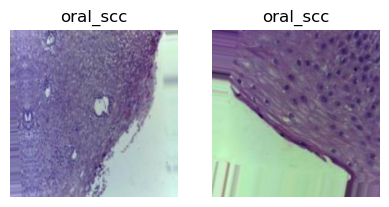

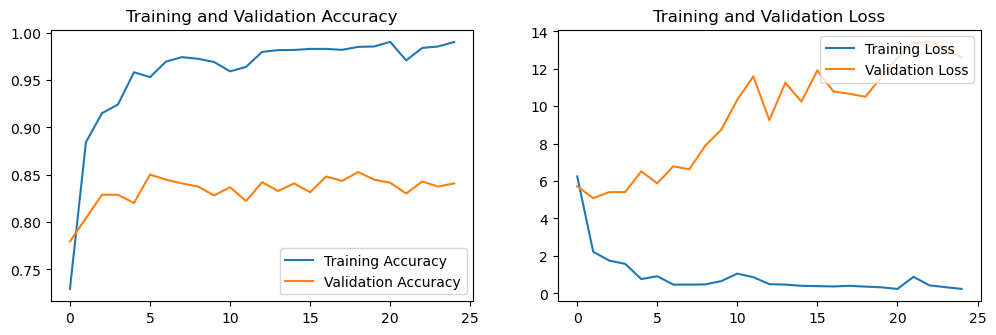

47/47 [==============================] - 6s 128ms/step - loss: 14.4798 - accuracy: 0.8302
Accuracy on the Test Set = 83.02 %
Model Saved!
True :  [0 0 0 ... 1 1 1]
47/47 [==============================] - 5s 110ms/step
Predicted :  [0 0 1 ... 1 1 1]
RECALL=0.8302263648468708
precision=0.8302269503546099
F1 Score0.8302262895927


<Figure size 640x480 with 0 Axes>

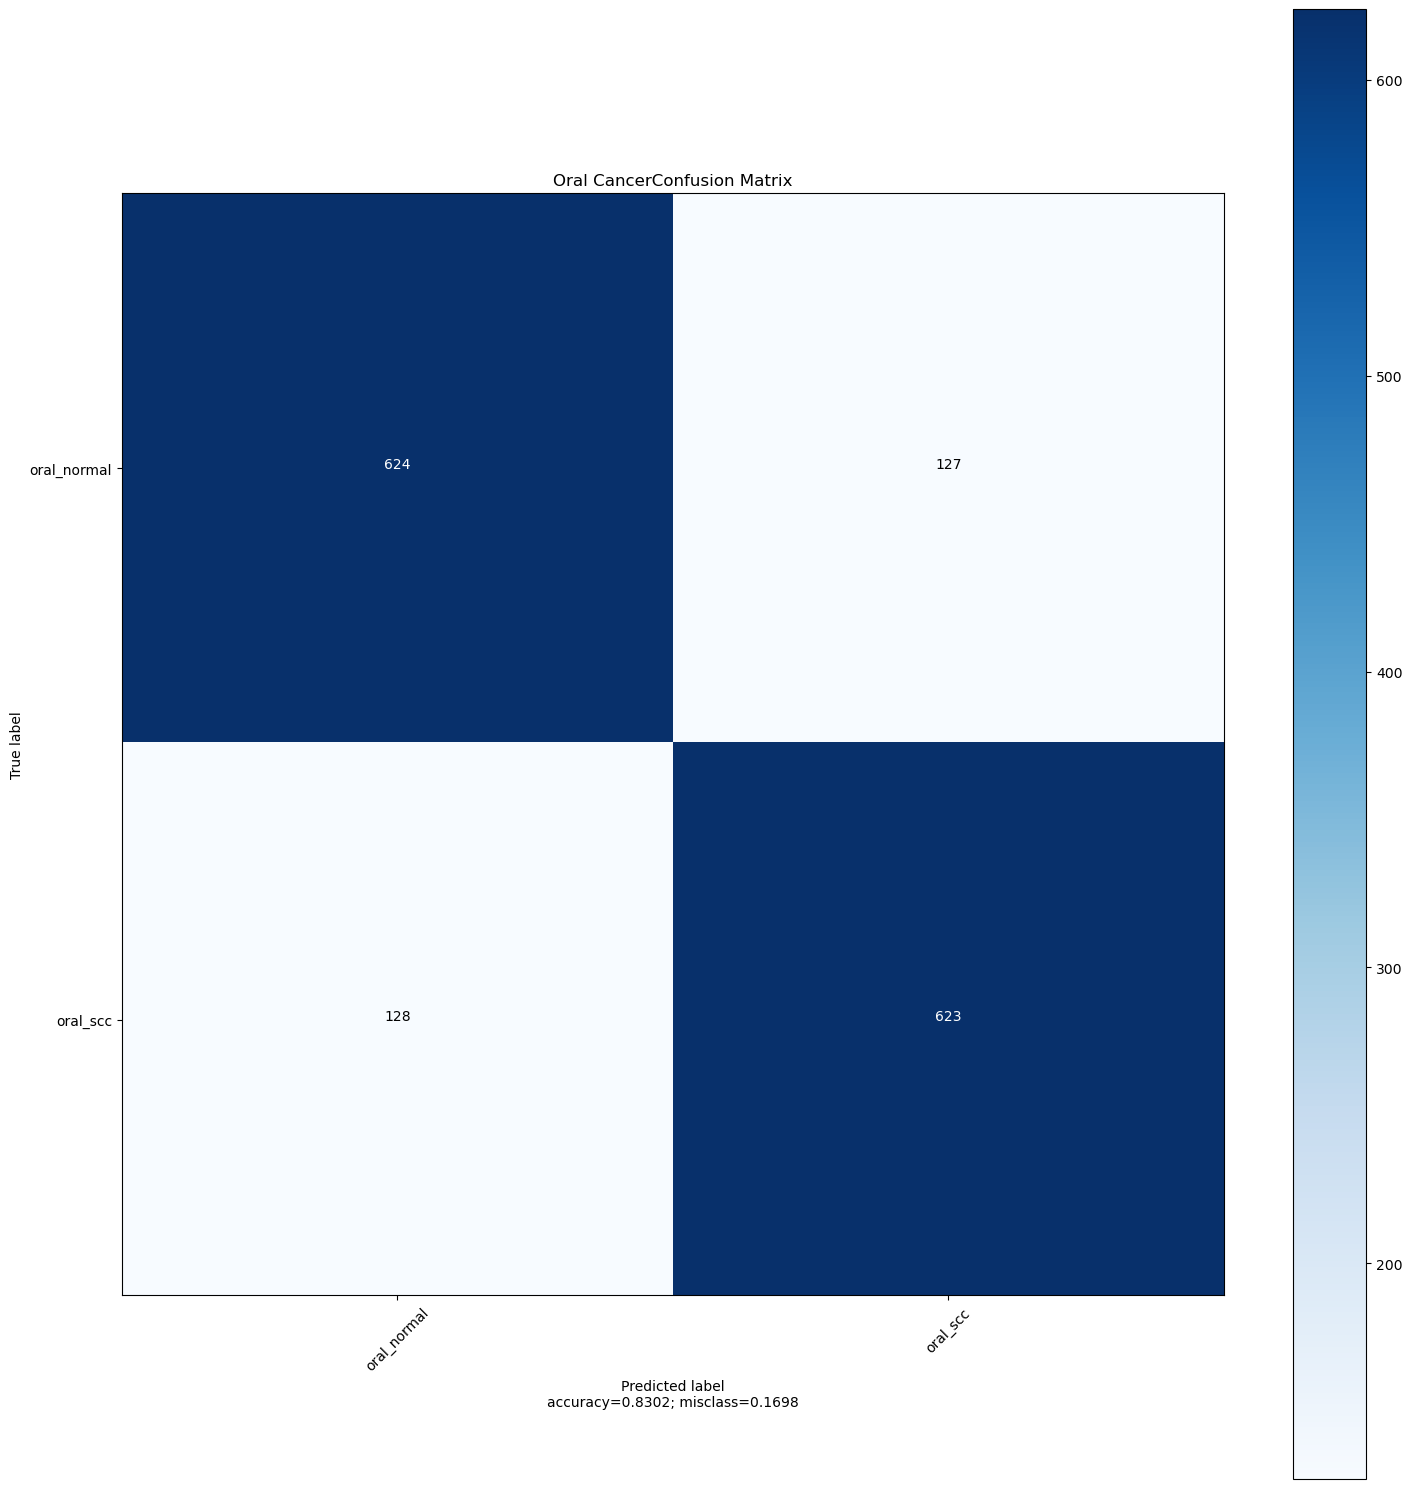

######################################################
RESULTS FORDenseNet201
Epoch 1/25
219/219 [==============================] - ETA: 0s - loss: 6.6695 - accuracy: 0.6896
Epoch 1: val_loss improved from inf to 7.39290, saving model to Oral CancerDenseNet201.h5
219/219 [==============================] - 45s 160ms/step - loss: 6.6695 - accuracy: 0.6896 - val_loss: 7.3929 - val_accuracy: 0.7133 - lr: 0.0010
Epoch 2/25
219/219 [==============================] - ETA: 0s - loss: 5.3140 - accuracy: 0.7604
Epoch 2: val_loss did not improve from 7.39290
219/219 [==============================] - 30s 138ms/step - loss: 5.3140 - accuracy: 0.7604 - val_loss: 8.8797 - val_accuracy: 0.7287 - lr: 0.0010
Epoch 3/25
219/219 [==============================] - ETA: 0s - loss: 3.8748 - accuracy: 0.8127
Epoch 3: val_loss improved from 7.39290 to 4.36152, saving model to Oral CancerDenseNet201.h5
219/219 [==============================] - 32s 144ms/step - loss: 3.8748 - accuracy: 0.8127 - val_loss: 4.361

<Figure size 640x480 with 0 Axes>

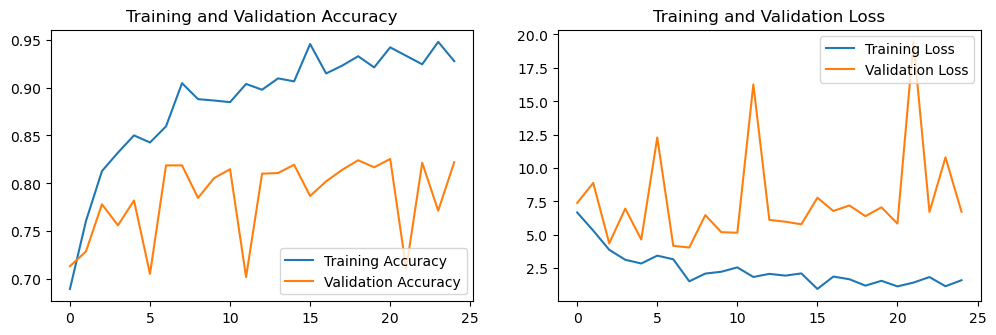

47/47 [==============================] - 8s 165ms/step - loss: 6.0111 - accuracy: 0.8362
Accuracy on the Test Set = 83.62 %
Model Saved!
True :  [0 0 0 ... 1 1 1]
47/47 [==============================] - 8s 113ms/step
Predicted :  [0 0 1 ... 1 1 1]
RECALL=0.8362183754993342
precision=0.8406859442513094
F1 Score0.835679673824873


<Figure size 640x480 with 0 Axes>

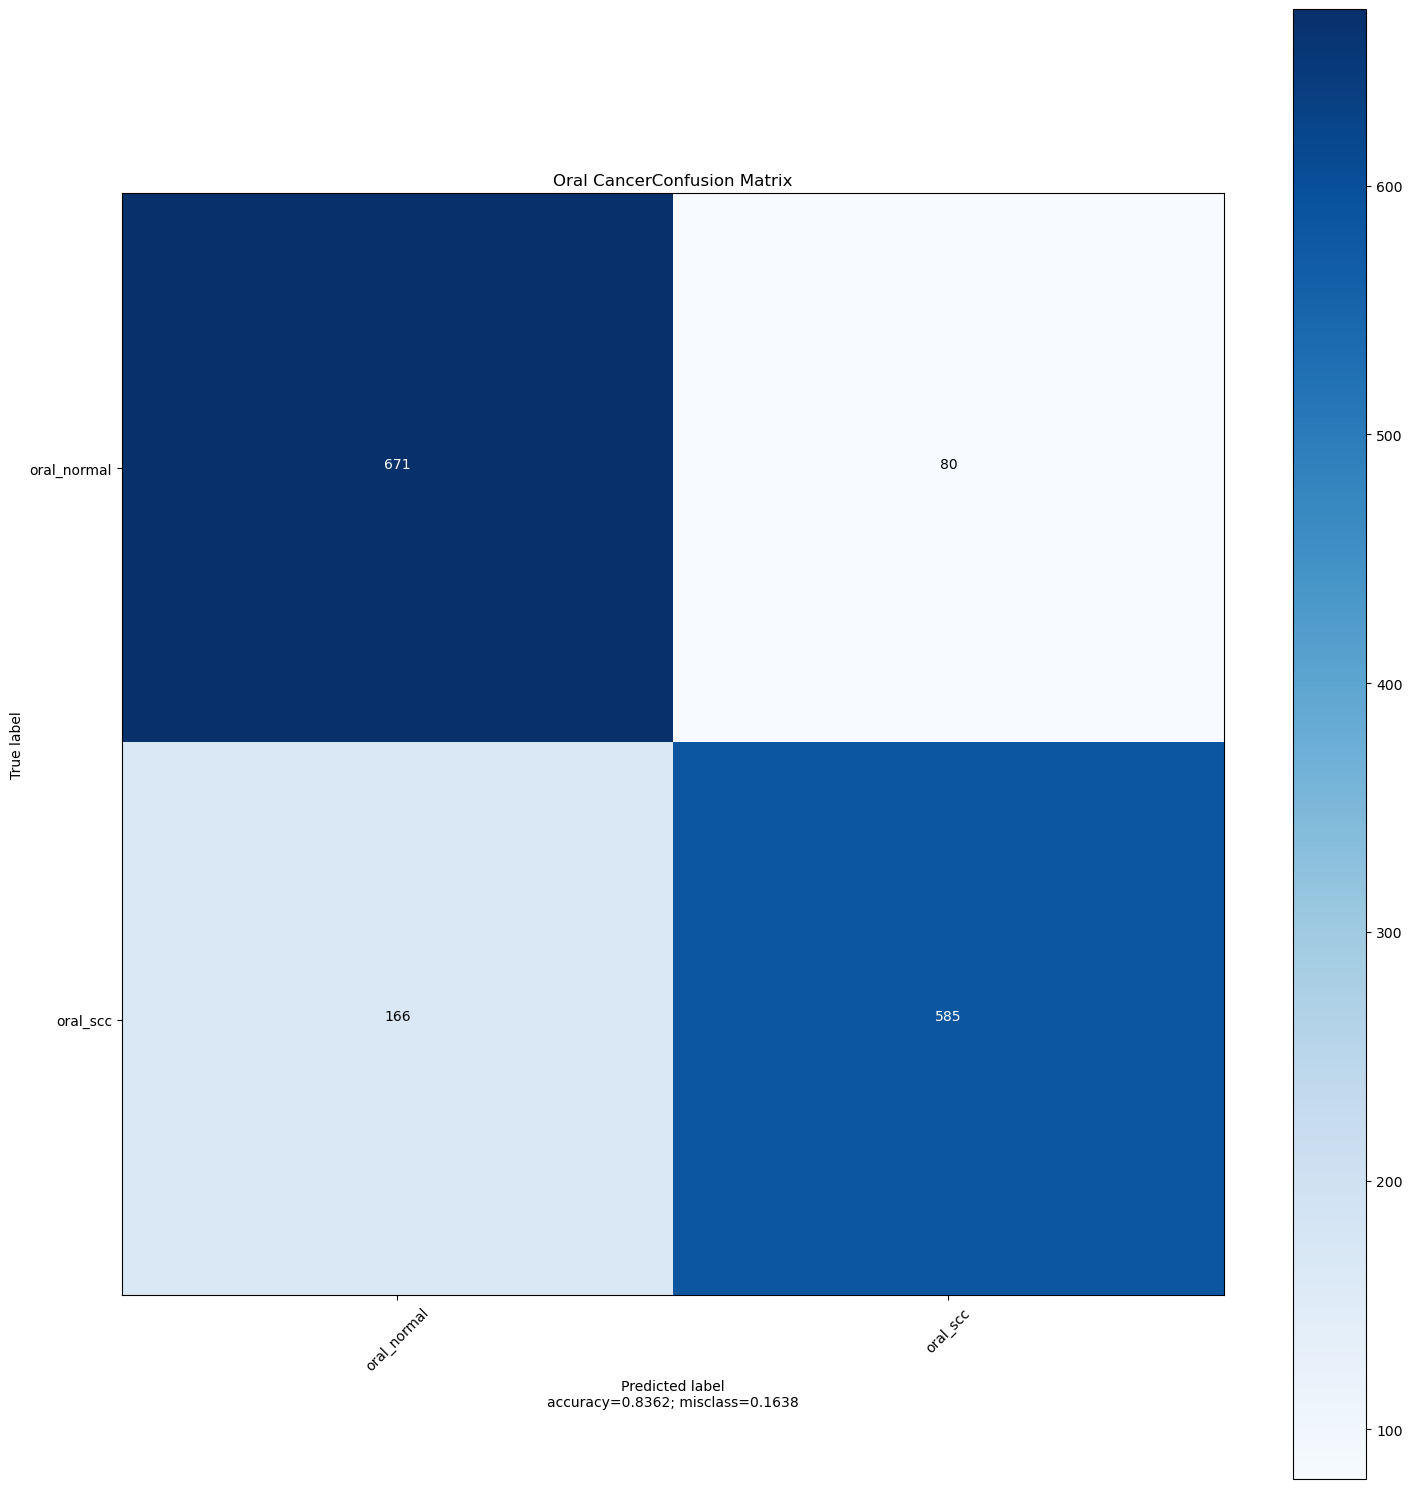

######################################################
RESULTS FORMobileNetV3
4334752/4334752 [==============================] - 1s 0us/step
Epoch 1/25
219/219 [==============================] - ETA: 0s - loss: 1.2012 - accuracy: 0.7619
Epoch 1: val_loss improved from inf to 1.37825, saving model to Oral CancerMobileNetV3.h5
219/219 [==============================] - 31s 123ms/step - loss: 1.2012 - accuracy: 0.7619 - val_loss: 1.3782 - val_accuracy: 0.7760 - lr: 0.0010
Epoch 2/25
219/219 [==============================] - ETA: 0s - loss: 0.6161 - accuracy: 0.8814
Epoch 2: val_loss improved from 1.37825 to 1.19201, saving model to Oral CancerMobileNetV3.h5
219/219 [==============================] - 26s 120ms/step - loss: 0.6161 - accuracy: 0.8814 - val_loss: 1.1920 - val_accuracy: 0.8260 - lr: 0.0010
Epoch 3/25
219/219 [==============================] - ETA: 0s - loss: 0.2259 - accuracy: 0.9439
Epoch 3: val_loss improved from 1.19201 to 1.05724, saving model to Oral CancerMobileNetV3.h5

<Figure size 640x480 with 0 Axes>

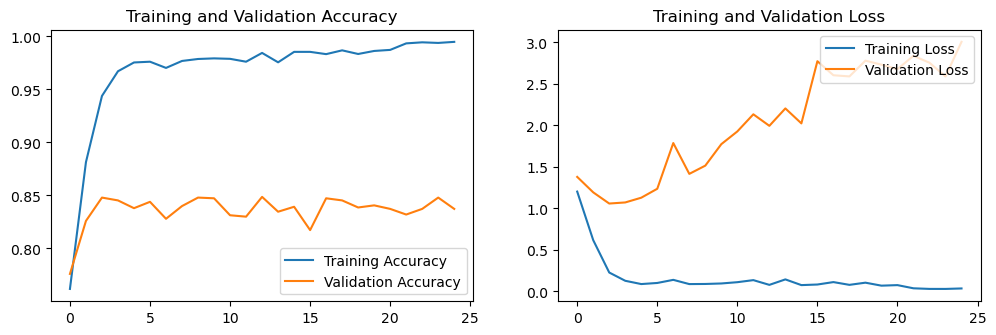

47/47 [==============================] - 5s 106ms/step - loss: 2.5272 - accuracy: 0.8495
Accuracy on the Test Set = 84.95 %
Model Saved!
True :  [0 0 0 ... 1 1 1]
47/47 [==============================] - 6s 100ms/step
Predicted :  [0 0 0 ... 1 1 1]
RECALL=0.8495339547270306
precision=0.8495364337044347
F1 Score0.8495336879432624


<Figure size 640x480 with 0 Axes>

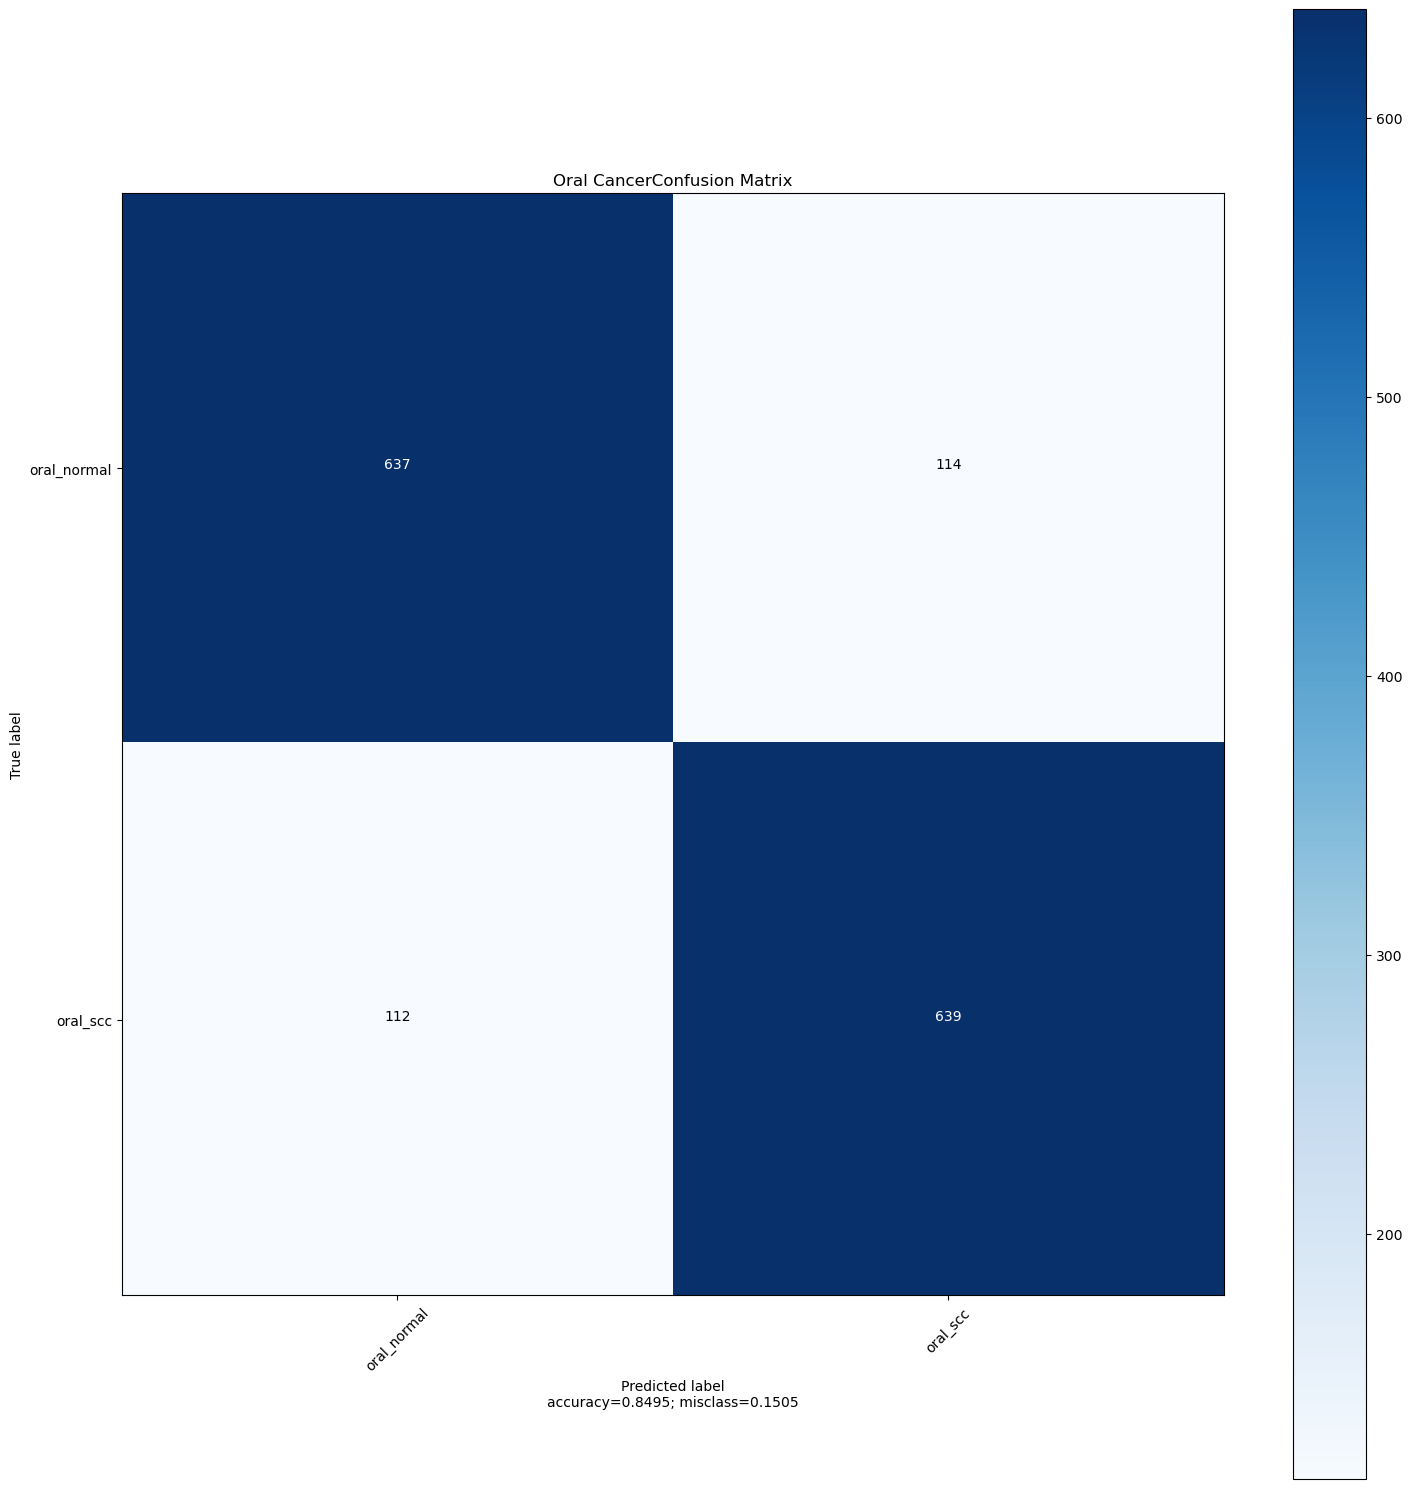

######################################################
RESULTS FORResNet50V2
94668760/94668760 [==============================] - 4s 0us/step
Epoch 1/25
219/219 [==============================] - ETA: 0s - loss: 218.8737 - accuracy: 0.6256
Epoch 1: val_loss improved from inf to 84.98959, saving model to Oral CancerResNet50V2.h5
219/219 [==============================] - 34s 139ms/step - loss: 218.8737 - accuracy: 0.6256 - val_loss: 84.9896 - val_accuracy: 0.7053 - lr: 0.0010
Epoch 2/25
219/219 [==============================] - ETA: 0s - loss: 107.0948 - accuracy: 0.7193
Epoch 2: val_loss improved from 84.98959 to 57.96504, saving model to Oral CancerResNet50V2.h5
219/219 [==============================] - 28s 129ms/step - loss: 107.0948 - accuracy: 0.7193 - val_loss: 57.9650 - val_accuracy: 0.7460 - lr: 0.0010
Epoch 3/25
219/219 [==============================] - ETA: 0s - loss: 62.2961 - accuracy: 0.7599
Epoch 3: val_loss improved from 57.96504 to 54.56446, saving model to Oral Cance

<Figure size 640x480 with 0 Axes>

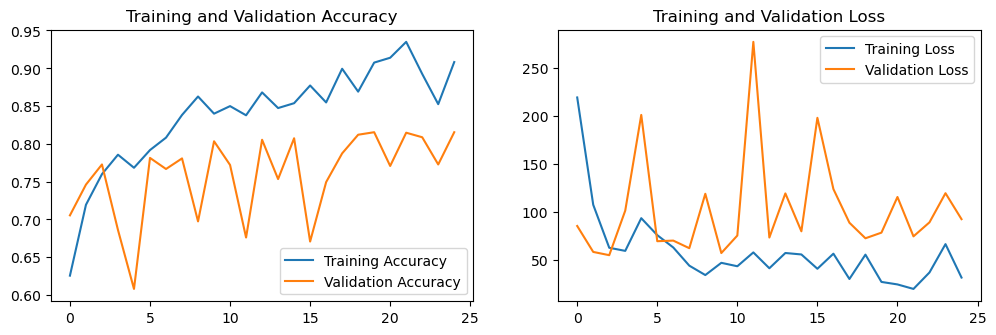

47/47 [==============================] - 6s 120ms/step - loss: 92.2129 - accuracy: 0.8056
Accuracy on the Test Set = 80.56 %
Model Saved!
True :  [0 0 0 ... 1 1 1]
47/47 [==============================] - 6s 111ms/step
Predicted :  [0 0 1 ... 0 1 0]
RECALL=0.8055925432756325
precision=0.8071807301923951
F1 Score0.8053409365280007


<Figure size 640x480 with 0 Axes>

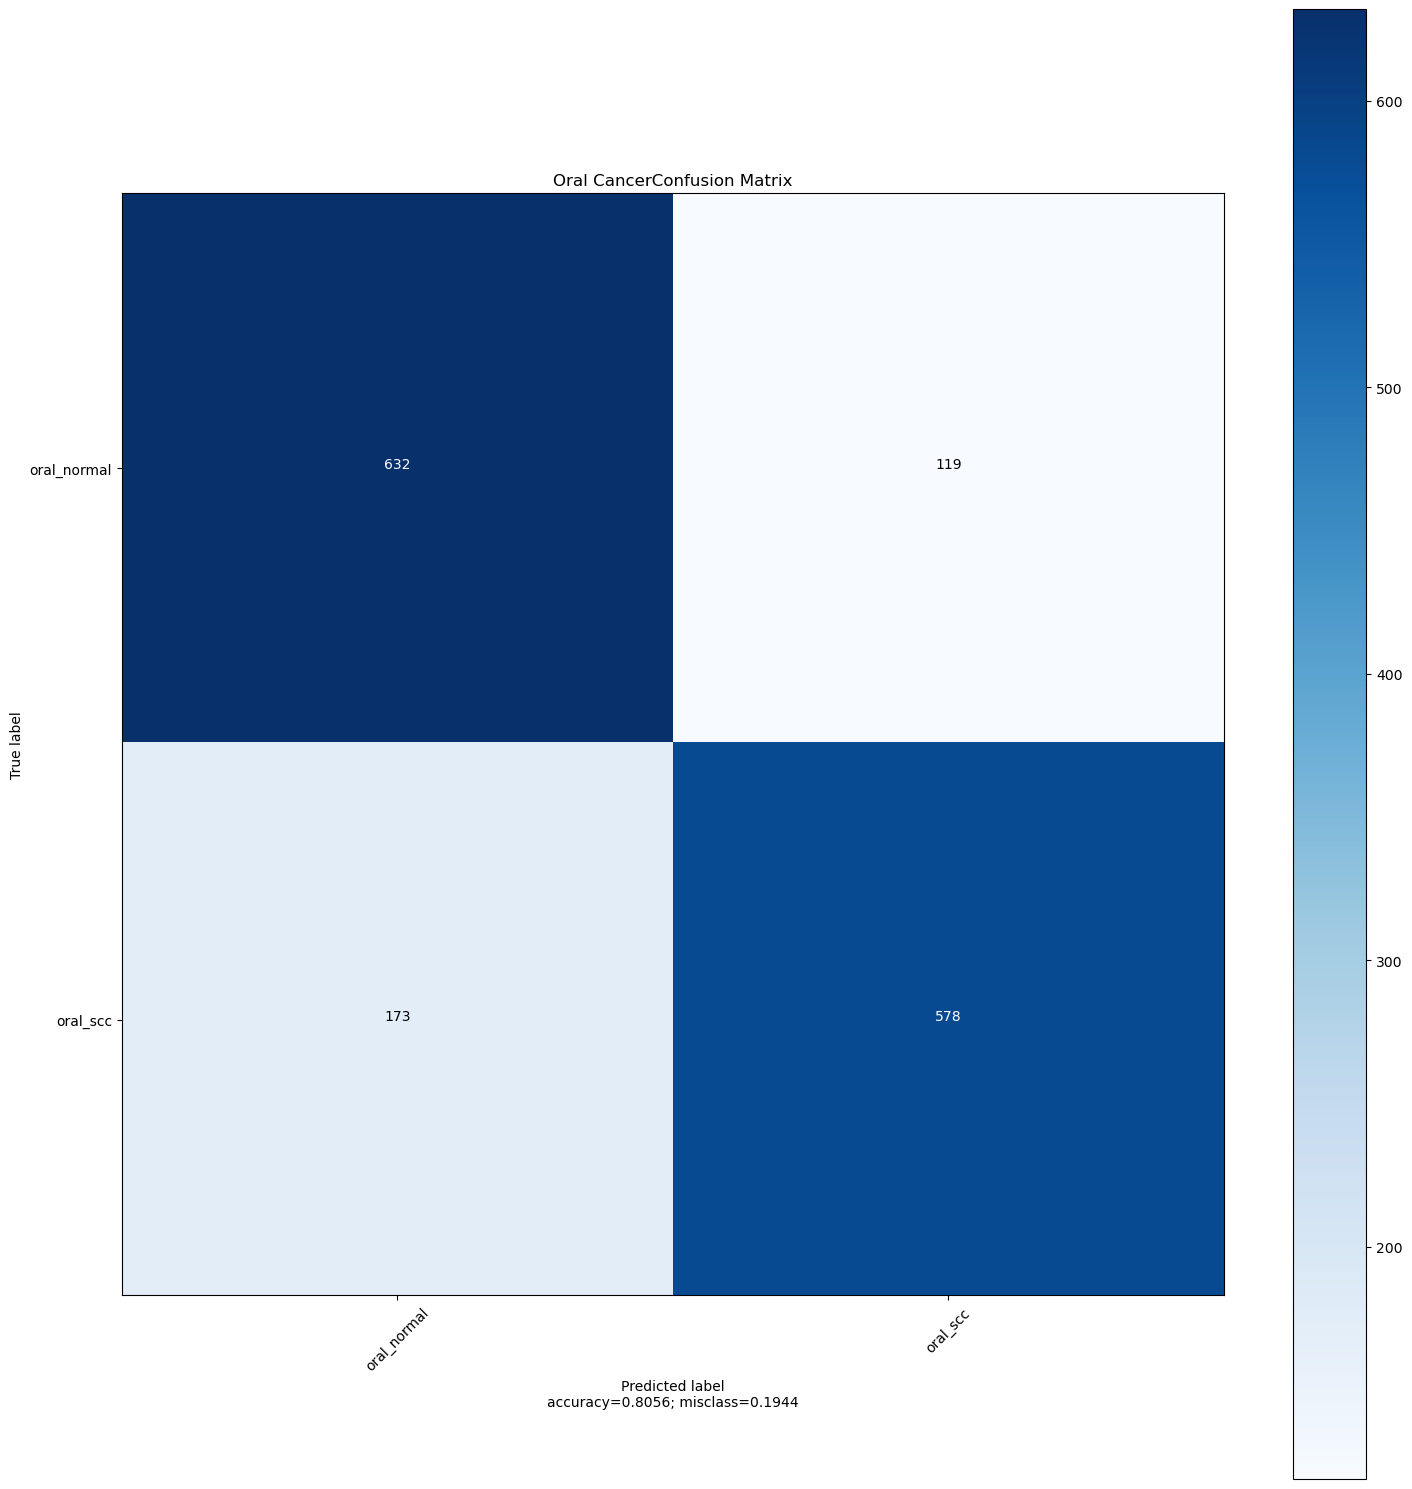

######################################################
RESULTS FOR ENSEMBLE
True :  [0 0 0 ... 1 1 1]
47/47 [==============================] - 5s 105ms/step
Predicted :  [0 0 1 ... 1 1 1]
RECALL=0.9001331557922769
precision=0.9006901425205559
F1 Score0.9000984382898342


<Figure size 640x480 with 0 Axes>

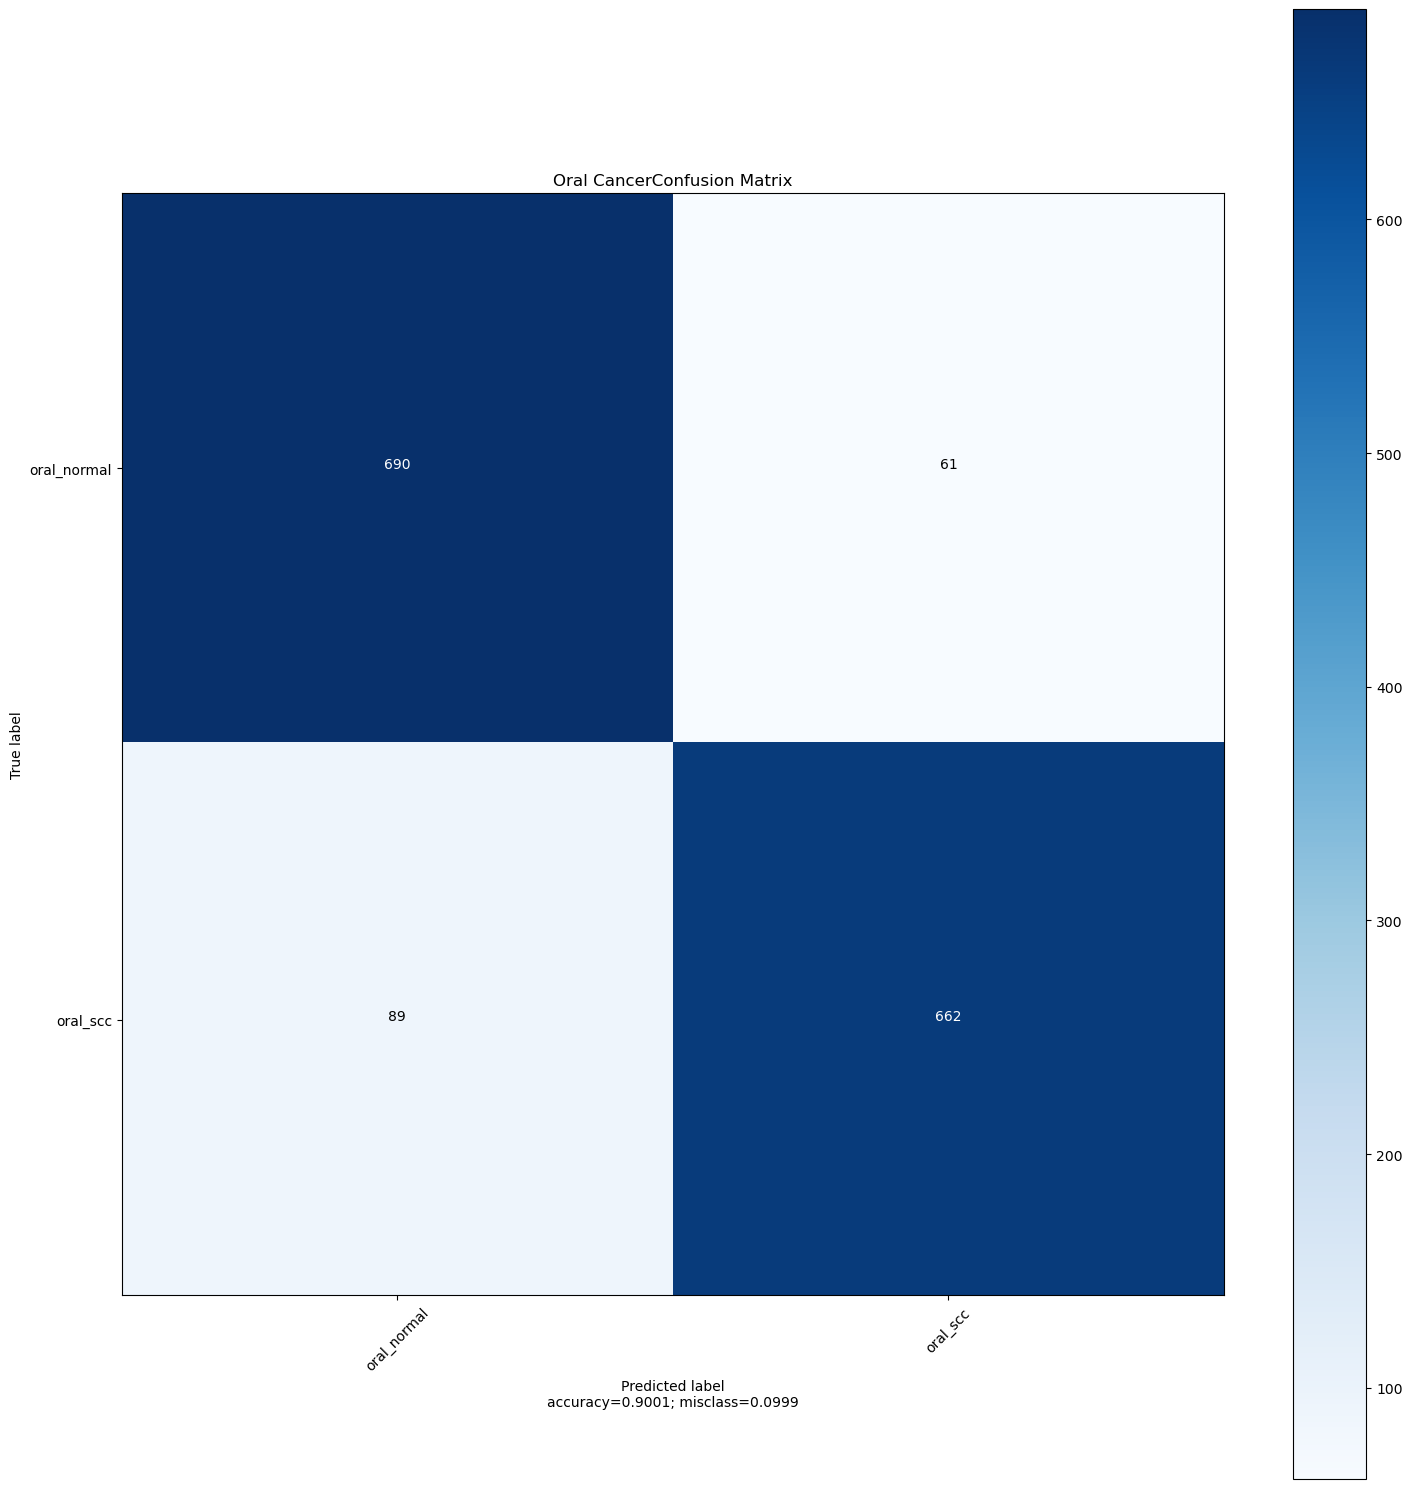

<Figure size 640x480 with 0 Axes>

In [36]:
for c in classPaths[2:3]:
    className = c
#     model_name="VGG-19"
    cpath = os.path.join(mpath, c)
    noOfClasses, class_names, train_generator, validation_generator,test_generator = initiateGenerator(cpath)
    part[c]['ClassNames']=class_names
    
    
    
    model_name="VGG-19"
    print("######################################################")
    print(f"RESULTS FOR{model_name}")
    curVGG19 = initiateVGG19(noOfClasses)
    #modelSummary(curVGG19)
    curVGG19, annealer, checkpoint = initiateParams(className, curVGG19, lr,model_name)
    curHistory = modelFit(curVGG19, annealer, checkpoint, epochs=gEpochs, batchSize=256)
    plotOutput(curHistory, className, gEpochs)
    acc=evalModel(curVGG19)
    
    saveModel(curVGG19, className,model_name)
    part[c]['models']['VGG19']={"model":curVGG19,'Accurary':acc}
    callPlot(curVGG19, className, class_names)
    
    model_name="DenseNet201"
    print("######################################################")
    print(f"RESULTS FOR{model_name}")
    curDenseNet201= initiateDenseNet201(noOfClasses)
    #modelSummary(curDenseNet201)
    curDenseNet201, annealer, checkpoint = initiateParams(className, curDenseNet201, lr,model_name)
    curHistory = modelFit(curDenseNet201, annealer, checkpoint, epochs=gEpochs, batchSize=256)
    plotOutput(curHistory, className, gEpochs)
    acc=evalModel(curDenseNet201)
    saveModel(curDenseNet201, className,model_name)
    part[c]['models']['DenseNet201']={"model":curDenseNet201,'Accurary':acc}
    callPlot(curDenseNet201, className, class_names)
    
    
    
    model_name="MobileNetV3"
    print("######################################################")
    print(f"RESULTS FOR{model_name}")
    curMobileNetV3 = initiateMobileNetV3(noOfClasses)
    #modelSummary(curMobileNetV3)
    curMobileNetV3, annealer, checkpoint = initiateParams(className, curMobileNetV3, lr,model_name)
    curHistory = modelFit(curMobileNetV3, annealer, checkpoint, epochs=gEpochs, batchSize=256)
    plotOutput(curHistory, className, gEpochs)
    acc=evalModel(curMobileNetV3)
    saveModel(curMobileNetV3, className,model_name)
    part[c]['models']['MobileNetV3']={"model":curMobileNetV3,'Accurary':acc}
    callPlot(curMobileNetV3, className, class_names)
    
    model_name="ResNet50V2"
    print("######################################################")
    print(f"RESULTS FOR{model_name}")
    curResNet50V2 = initiateResNet50V2(noOfClasses)
    #modelSummary(curResNet50V2)
    curResNet50V2, annealer, checkpoint = initiateParams(className, curResNet50V2, lr,model_name)
    curHistory = modelFit(curResNet50V2, annealer, checkpoint, epochs=gEpochs, batchSize=256)
    plotOutput(curHistory, className, gEpochs)
    acc=evalModel(curResNet50V2)
    saveModel(curResNet50V2, className,model_name)
    part[c]['models']['ResNet50V2']={"model":curResNet50V2,'Accurary':acc}
    callPlot(curResNet50V2, className, class_names)
    print("######################################################")
    print(f"RESULTS FOR ENSEMBLE")
    Ensemble(c)
    
    
    